In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../preprocessed_data.txt', header=None, names=['tokens'])

In [3]:
data.head()

,tokens
0,? (film) also written tanda tanya meaning ques...
1,0.999... mathematics 0999 also written 09 09 0...
2,1 − 2 + 3 − 4 + ⋯ mathematics 1 2 3 4 infinite...
3,1 Line (Sound Transit) 1 line formerly central...
4,1st Cavalry Division (Kingdom of Yugoslavia) 1...


In [4]:
data.shape

(6428, 1)

In [5]:
tokens = data["tokens"]

In [6]:
# Import CountVectorizer from sklearn
from sklearn.feature_extraction.text import CountVectorizer

# Insantiate CountVectorizer
vectorizer = CountVectorizer()

tokenized_data = tokens

vectorizer.fit(tokenized_data)

CountVectorizer()

In [7]:
document_term_matrix = vectorizer.transform(tokenized_data)

In [8]:
# Print the document-term matrix as a dense array
print(document_term_matrix.toarray())

# Get the feature names
print(vectorizer.get_feature_names_out())

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['00' '000' '0000' ... 'đảng' 'đức' 'ōkami']


## Topic Modeling

In [9]:
from sklearn.decomposition import NMF

# Define the number of components
n_components = 10

# Initialize NMF 
nmf = NMF(n_components=n_components, init='nndsvd', random_state=0)
nmf_features = nmf.fit_transform(document_term_matrix)

# For loop to iterate through topics
for topic_idx in range(n_components):
    top_words = [vectorizer.get_feature_names_out()[i] for i in nmf.components_[topic_idx].argsort()[-10:]][::-1]
    print(f"Topic {topic_idx+1}: {top_words}")

Topic 1: ['state', 'would', 'new', 'president', 'government', 'party', 'american', 'united', 'war', 'election']
Topic 2: ['game', 'player', 'team', 'character', 'series', 'released', 'one', 'also', 'sonic', 'version']
Topic 3: ['film', 'character', 'role', 'time', 'one', 'scene', 'said', 'also', 'best', 'series']
Topic 4: ['specie', 'also', 'may', 'found', 'one', 'bird', 'used', 'known', 'year', 'two']
Topic 5: ['ship', 'fleet', 'gun', 'two', 'british', 'navy', 'battleship', 'sea', 'naval', 'squadron']
Topic 6: ['first', 'season', 'team', 'match', 'league', 'club', 'second', 'two', 'player', 'run']
Topic 7: ['album', 'song', 'music', 'band', 'released', 'single', 'first', 'record', 'one', 'number']
Topic 8: ['city', 'river', 'park', 'area', 'state', 'road', 'highway', 'north', 'building', 'new']
Topic 9: ['king', 'work', 'henry', 'year', 'first', 'one', 'also', 'time', 'england', 'later']
Topic 10: ['army', 'force', 'division', 'war', 'german', 'attack', 'battle', 'japanese', 'troop', 

### Generate Word Embeddings with BERT a pretrained model

- Using hf `transformers` library to generate embeddings from pretrained model

In [10]:
import torch

In [ ]:
# !pip install transformers torch

- We have CUDA and pytorch installed so we can use GPU

In [11]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4070 Ti


In [12]:
print(torch.__version__)
print(torch.version.cuda)

2.2.0+cu121
12.1


In [13]:
from transformers import BertTokenizer, BertModel
import torch

def generate_embeddings(texts):
    # Initialize the tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    
    # Check if a GPU is available and move the model to GPU if so
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Ensure model is in evaluation mode
    model.eval()
    
    # Tokenize texts and prepare input tensors
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Generate embeddings
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Keep the embeddings on the GPU
    embeddings = outputs.last_hidden_state[:, 0, :]

    return embeddings

In [14]:
def generate_embeddings_in_batches(texts, batch_size=32):
    # Initialize an empty tensor for storing embeddings
    all_embeddings = torch.tensor([], device='cuda')
    
    # Process texts in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = generate_embeddings(batch_texts)
        
        # Concatenate the current batch embeddings with the previous ones
        all_embeddings = torch.cat((all_embeddings, batch_embeddings), dim=0)
    
    return all_embeddings

In [15]:
texts = data['tokens'].tolist()  
document_embeddings = generate_embeddings_in_batches(texts, batch_size=32)

In [16]:
print(document_embeddings)

tensor([[-0.2125, -0.0303,  0.4885,  ..., -0.4554,  0.1535, -0.3072],
        [-0.5451,  0.4453,  0.0585,  ..., -0.5824,  0.1367,  0.4332],
        [-0.2722,  0.2319,  0.3040,  ..., -0.6462,  0.1486,  0.3544],
        ...,
        [-0.4336,  0.1492,  0.2508,  ..., -0.4408,  0.2185,  0.0876],
        [-0.4039,  0.2261, -0.1054,  ..., -0.4469, -0.0176, -0.0395],
        [-0.5113,  0.0193,  0.3418,  ..., -0.7227,  0.2228,  0.0116]],
       device='cuda:0')


In [17]:
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=42, metric=cosine)
clusters = kmeans.fit_predict(document_embeddings.cpu().numpy())  # Move embeddings to CPU and convert to NumPy array for sklearn

/home/dreampy/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# !pip install matplotlib

In [21]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Let's use PCA for dimensionality reduction
reduced_embeddings = PCA(n_components=2).fit_transform(document_embeddings.cpu().numpy())

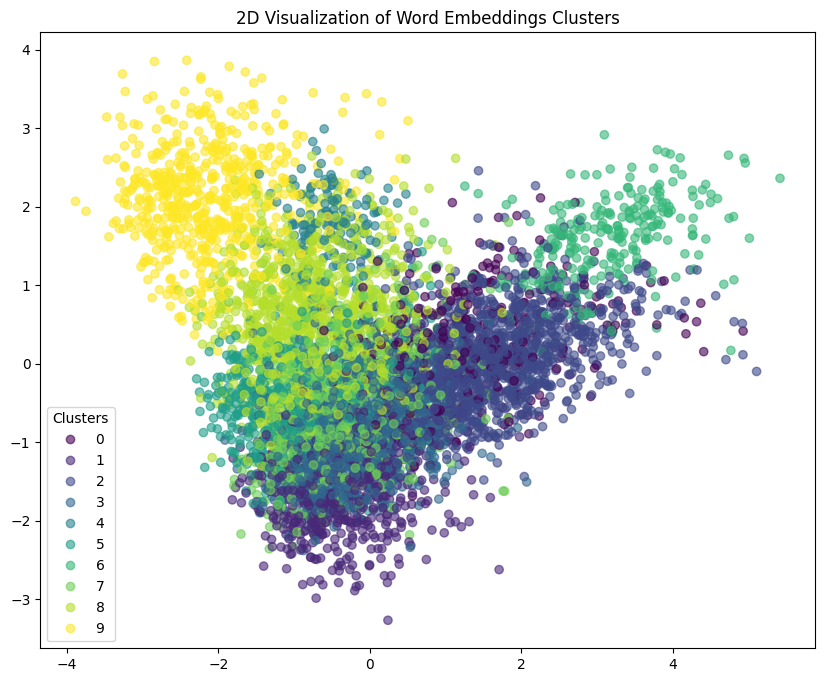

In [22]:
import matplotlib.pyplot as plt

# Scatter plot of the reduced embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', alpha=0.6)

# Adding a legend
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('2D Visualization of Word Embeddings Clusters')
plt.show()

#### Silhouette score 

In [18]:
from sklearn.metrics import silhouette_score

# `document_embeddings` are document embeddings and `clusters` are the labels from KMeans
silhouette_avg = silhouette_score(document_embeddings.cpu().numpy(), clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.07384935766458511


We can calculate scores using the elbow method to try to find the optimal n_clusters, we are looking to improve the `Silhouette Score ~ 0.074` to something that is closer to 1 

/home/dreampy/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dreampy/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dreampy/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dreampy/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: Fut

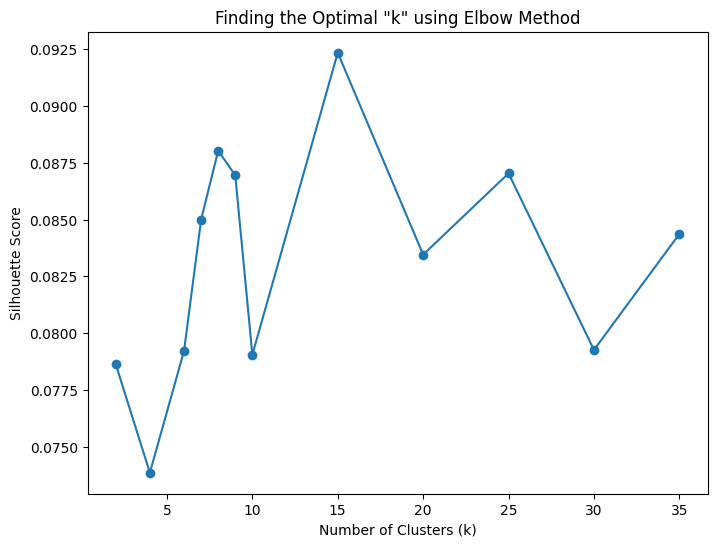

In [25]:
# Range of cluster numbers to try
range_n_clusters = [2, 4, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35] 

# Calculate silhouette scores
silhouette_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(document_embeddings.cpu().numpy())

    silhouette_avg = silhouette_score(document_embeddings.cpu().numpy(), clusters)
    silhouette_scores.append(silhouette_avg)

# Elbow method: Plot silhouette scores
plt.figure(figsize=(8,6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Finding the Optimal "k" using Elbow Method')
plt.show()

#### Looks like n_clusters = 15 is optimal for our embeddings

In [29]:
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(document_embeddings.cpu().numpy())  # Move embeddings to CPU and convert to NumPy array for sklearn

/home/dreampy/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Let's replot our data with the optimal n_clusters

In [30]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Let's use PCA for dimensionality reduction
reduced_embeddings = PCA(n_components=2).fit_transform(document_embeddings.cpu().numpy())

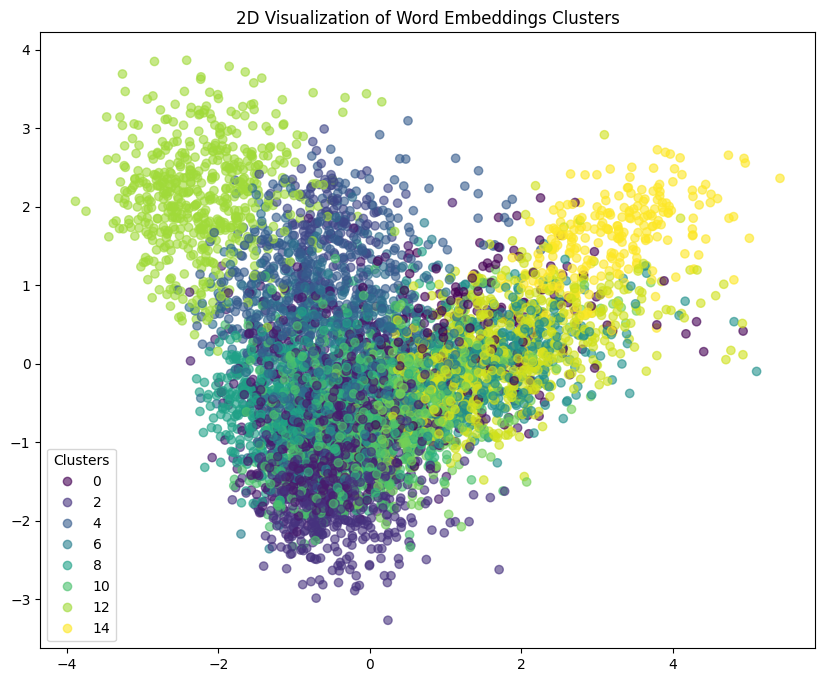

In [31]:
import matplotlib.pyplot as plt

# Scatter plot of the reduced embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', alpha=0.6)

# Adding a legend
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('2D Visualization of Word Embeddings Clusters')
plt.show()

In [27]:
query_text = "When did the second world war start?"
query_embedding = generate_embeddings([query_text]) 

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

# Ensure query_embedding is a 2D array and on CPU
if query_embedding.ndim == 1:
    query_embedding = query_embedding.unsqueeze(0) 
query_embedding = query_embedding.cpu().numpy() if torch.is_tensor(query_embedding) else query_embedding

# Ensure document_embeddings is on CPU to use with numpy
document_embeddings_np = document_embeddings.cpu().numpy() if torch.is_tensor(document_embeddings) else document_embeddings

# Calculate cosine similarities
cosine_similarities = cosine_similarity(query_embedding, document_embeddings_np)

In [29]:
# Get the sorted indices of documents based on similarity scores
sorted_doc_indices = cosine_similarities.argsort()[0][::-1]

for idx in sorted_doc_indices[:5]:  
    print(f"Document {idx} Similarity: {cosine_similarities[0][idx]}")
    # Display the document text

Document 5577 Similarity: 0.7549175024032593
Document 1809 Similarity: 0.7503839731216431
Document 2007 Similarity: 0.7450723648071289
Document 4914 Similarity: 0.745018720626831
Document 308 Similarity: 0.7295743823051453


In [ ]:
# !pip install annoy

In [35]:
from annoy import AnnoyIndex
import numpy as np

embedding_dim = document_embeddings.shape[1]

# Create Annoy index
t = AnnoyIndex(embedding_dim, 'angular')  # 'angular' or 'eucledian'

# Add items to the index
for i in range(len(document_embeddings)):
    t.add_item(i, document_embeddings[i])

# Build the index
t.build(1000)  # 10 trees; more trees = higher precision when querying
t.save('document_embeddings.ann')

True

In [36]:
# Load the index 
u = AnnoyIndex(embedding_dim, 'angular')
u.load('document_embeddings.ann')  

# To query the index, provide the vector of the query document and the number of nearest neighbors
query_embedding = generate_embeddings([query_text])[0]
n_neighbors = 5  # Number of nearest neighbors to retrieve

nearest_neighbors = u.get_nns_by_vector(query_embedding, n_neighbors, include_distances=True)
print(nearest_neighbors)

([5577, 1809, 2007, 4914, 308], [0.7001178860664368, 0.7065638303756714, 0.7140416502952576, 0.7141165733337402, 0.7354260683059692])


In [37]:
document_indices, distances = nearest_neighbors

for idx, distance in zip(document_indices, distances):
    print(f"Document index: {idx}, Distance: {distance}")
    # Retrieve and display the actual document using `idx`

Document index: 5577, Distance: 0.7001178860664368
Document index: 1809, Distance: 0.7065638303756714
Document index: 2007, Distance: 0.7140416502952576
Document index: 4914, Distance: 0.7141165733337402
Document index: 308, Distance: 0.7354260683059692


In [39]:
for idx, distance in [(5577, 0.7001), (1809, 0.7065), (2007, 0.7140), (4914, 0.7141), (308, 0.7354)]:
    print(f"Document {idx} (Distance: {distance}):\n{tokens[idx]}\n")

Document 5577 (Distance: 0.7001):
Sutton Hoo Helmet (sculpture) sutton hoo helmet 2002 sculpture english artist rick kirby representation anglosaxon helmet name found sutton hoo shipburial commissioned national trust suspend outside exhibition hall sutton hoo visitor centre opening centre sculpture unveiled literature nobel laureate seamus heaney 13 march 2002 remained place dominating entrance exhibition hall 2019 moved entrance sutton hoo site sculpture 18 59 ft high 12 39 ft wide 16 52 ft deep weighs 900 kg 2000 lb made mild steel plate coloured red designed fierce presence inspired fragmentary appearance reconstructed helmet rather glistening replica made royal armoury steel kirbys favoured medium allowing sense scale dramatic impact found sutton hoo helmet sculpture illustrative kirbys largely figural body work masklike quality repeated subsequent piece 1939 archaeologist excavating barrow overlooking river deben near woodbridge suffolk discovered anglosaxon grave unparalleled wea

In [ ]:
query_text = "What are the key features of quantum computing?"
query_embedding = generate_embeddings([query_text])[0]  # Get the first (and only) embedding

In [ ]:
from annoy import AnnoyIndex

# Load the Annoy index
embedding_dim = query_embedding.shape[0] 
annoy_index = AnnoyIndex(embedding_dim, 'angular')  
annoy_index.load('document_embeddings.ann')  

# Find the nearest neighbors
n_neighbors = 5  # Number of nearest neighbors to find
nearest_neighbors_ids = annoy_index.get_nns_by_vector(query_embedding, n_neighbors, include_distances=True)

print("Nearest Neighbors IDs and Distances:", nearest_neighbors_ids)